<a href="https://colab.research.google.com/github/eflores5000/estrategia2/blob/main/Prueba_inicial_completa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Es una prueba en github

In [1]:
# Nos aseguramos que tenemos instalada la última versión de la API de Kaggle en Colab
!pip install --upgrade --force-reinstall --no-deps kaggle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.2
    Uninstalling kaggle-1.7.4.2:
      Successfully uninstalled kaggle-1.7.4.2


In [2]:
#%%capture
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files
files.upload()
#uploaded = files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eduflowers","key":"8cf8eb7e9d3d4d836fe29bda7df108d9"}'}

In [3]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [16]:
# Ya podemos listar los datasets disponibles en kaggle para su descarga
#!kaggle datasets list


In [6]:
# AHORA SI: Descarguemos un dataset de cierta competición
#!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ifigotin/imagenetmini-1000")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imagenetmini-1000


In [17]:
# Creemos un directorio para descomprimir los datos
#!mkdir my_dataset


In [5]:
# Conectamos con nuestro Google Drive
from google.colab import drive
#drive.mount('/content/drive')
drive.mount('/kaggle/drive/', force_remount=True)


Mounted at /kaggle/drive/


In [7]:
# Mostrar un elemento del dataset
BASE_FOLDER = "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01440764/"
import matplotlib.pyplot as plt
import numpy as np
import cv2


/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01440764/n01440764_10043.JPEG


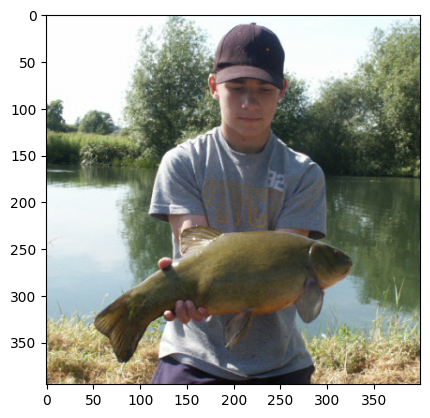

In [8]:
# Escogiendo y mostrando una imagen al azar del conjunto de test
#idx = np.random.randint(1, 1000)
#img = cv2.imread('test/' + str(idx) + '.jpg', cv2.COLOR_BGR2RGB)
nombre = BASE_FOLDER+'n01440764_' + '10043' + '.JPEG'
print(nombre)
img = cv2.imread(BASE_FOLDER+'n01440764_' + '10043' + '.JPEG', cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


## Configuración inicial

In [9]:
#pip install tensorflow numpy matplotlib

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0  # Puedes cambiar el modelo base
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Configuración
IMG_SIZE = (224, 224)  # Tamaño esperado por la mayoría de modelos pre-entrenados
BATCH_SIZE = 32
NUM_CLASSES = 1000  # Para ImageNetMini-1000
EPOCHS = 20
BASE_LEARNING_RATE = 1e-4
FINE_TUNE_LEARNING_RATE = 1e-5

## Carga y preparación de datos

In [10]:

## Preparación de datos para estructura train/val separados
def prepare_data(base_dir):
    # Directorios
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    '''
    # Crear generadores de datos con aumento de datos para entrenamiento
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Usamos 20% para validación
    )
    '''
    # Generador de datos solo con reescalado (sin data augmentation)
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Generador de entrenamiento
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    # Generador de validación
    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False  # Normalmente no se mezcla el conjunto de validación
    )

    # Verificar número de clases
    if train_generator.num_classes != NUM_CLASSES:
        raise ValueError(f"Número de clases encontradas ({train_generator.num_classes}) no coincide con {NUM_CLASSES}")

    return train_generator, validation_generator

# Suponiendo que el dataset está organizado en carpetas por clase
# Ejemplo de estructura:
# imagenetmini-1000/
#     class1/
#         img1.jpg
#         img2.jpg
#         ...
#     class2/
#         img1.jpg
#         ...
#data_dir = 'path/to/imagenetmini-1000'

data_dir = '/kaggle/input/imagenetmini-1000/imagenet-mini'
train_gen, val_gen = prepare_data(data_dir)


Found 34745 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.


## Construcción del modelo con Transfer Learning

In [11]:
def build_model(base_model_name='EfficientNetB0'):
    # Cargar modelo base pre-entrenado (sin la capa superior)
    if base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(
            input_shape=IMG_SIZE + (3,),
            include_top=False,
            weights='imagenet',
            pooling='avg'
        )
    # Puedes añadir más opciones de modelos aquí

    # Congelar las capas del modelo base
    base_model.trainable = False

    # Construir el modelo completo
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs, training=False)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    return model, base_model

# Crear modelo
model, base_model = build_model()
model.compile(
    optimizer=optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model_transfer.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    #patience=5,
    patience=0,
    restore_best_weights=True
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Entrenamiento inicial (Transfer Learning)

In [12]:
print("Entrenando capas superiores...")
history_transfer = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stopping]
)

Entrenando capas superiores...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.0018 - loss: 6.9125

1086/1086 ━━━━━━━━━━━━━━━━━━━━ 364s 306ms/step - accuracy: 0.0018 - loss: 6.9125 - val_accuracy: 0.0010 - val_loss: 6.9057
Epoch 2/20
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 135s 124ms/step - accuracy: 0.0031 - loss: 6.8831 - val_accuracy: 5.0981e-04 - val_loss: 6.9094


## Fine-Tuning del modelo

In [13]:
def fine_tune_model(model, base_model):
    # Descongelar las últimas N capas del modelo base
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  # Dejamos las últimas 10 capas entrenables
        layer.trainable = False

    # Recompilar el modelo con una tasa de aprendizaje más baja
    model.compile(
        optimizer=optimizers.Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Aplicar fine-tuning
model = fine_tune_model(model, base_model)

# Nuevos callbacks para fine-tuning
checkpoint_ft = ModelCheckpoint(
    'best_model_finetuned.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

print("Fine-tuning del modelo...")
history_finetune = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[checkpoint_ft, early_stopping]
)

Fine-tuning del modelo...
Epoch 1/20
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.0019 - loss: 6.9255

1086/1086 ━━━━━━━━━━━━━━━━━━━━ 185s 148ms/step - accuracy: 0.0019 - loss: 6.9255 - val_accuracy: 7.6472e-04 - val_loss: 6.9076
Epoch 2/20
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 139s 128ms/step - accuracy: 0.0033 - loss: 6.8966 - val_accuracy: 7.6472e-04 - val_loss: 6.9070
Epoch 3/20
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 139s 128ms/step - accuracy: 0.0030 - loss: 6.8839 - val_accuracy: 7.6472e-04 - val_loss: 6.9071


## Evaluación y guardado del modelo

In [16]:
# Evaluar el modelo final
test_loss, test_acc = model.evaluate(val_gen)
print(f"Precisión final en el conjunto de validación: {test_acc:.4f}")

# Guardar el modelo completo
model.save('imagenetmini_classifier.h5')

# Opcional: Guardar solo los pesos
model.save('imagenetmini_classifier_weights.h5')

123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 4.0890e-04 - loss: 6.9226


Precisión final en el conjunto de validación: 0.0008


## Visualización de resultados

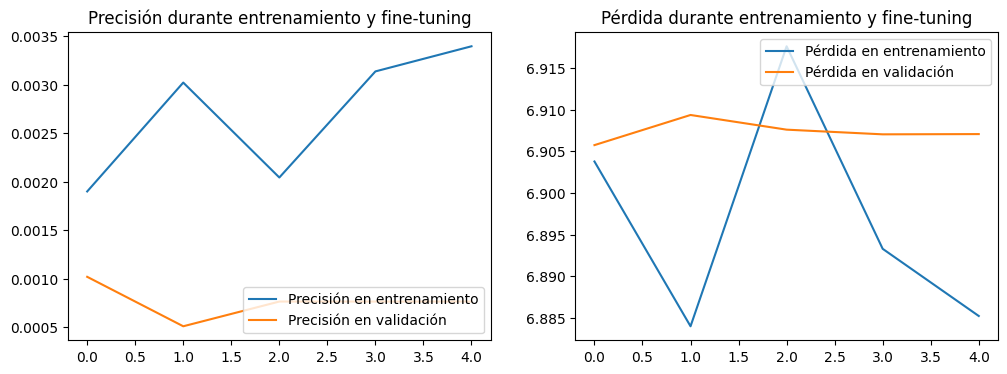

In [15]:
import matplotlib.pyplot as plt

def plot_history(transfer_history, fine_tune_history):
    # Combinar historiales
    acc = transfer_history.history['accuracy'] + fine_tune_history.history['accuracy']
    val_acc = transfer_history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
    loss = transfer_history.history['loss'] + fine_tune_history.history['loss']
    val_loss = transfer_history.history['val_loss'] + fine_tune_history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Precisión en entrenamiento')
    plt.plot(epochs_range, val_acc, label='Precisión en validación')
    plt.legend(loc='lower right')
    plt.title('Precisión durante entrenamiento y fine-tuning')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida en entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida en validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida durante entrenamiento y fine-tuning')

    plt.show()

plot_history(history_transfer, history_finetune)

Consideraciones importantes:
Estructura del dataset:

- Asegúrate de que el dataset esté organizado en carpetas por clase (cada clase es una carpeta con sus imágenes).

- Modelo base: He usado EfficientNetB0 por su buen equilibrio entre precisión y tamaño, pero puedes probar con otros como ResNet50, VGG16, etc.

- Recursos computacionales: Si tienes limitaciones de GPU, reduce el tamaño del batch o usa un modelo más pequeño.

- Fine-tuning: El código descongela las últimas 10 capas para fine-tuning. Puedes ajustar este número según tus necesidades.

- Aumento de datos: El ImageDataGenerator incluye transformaciones para evitar overfitting.